In [1]:
import numpy as np                 
import cv2                         
import glob                        
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

In [2]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog

def plot_row4(img1, img2, img3, img4, label_1, label_2, label_3, label_4, graysc=True):
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 4))
    f.tight_layout()
    if graysc:ax1.imshow(img1, cmap='gray')
    else:ax1.imshow(img1)
    ax1.set_title(label_1, fontsize=14)
    ax2.imshow(img2, cmap='gray')
    ax2.set_title(label_2, fontsize=14)
    ax3.imshow(img3, cmap='gray')
    ax3.set_title(label_3, fontsize=14)
    ax4.imshow(img4, cmap='gray')
    ax4.set_title(label_4, fontsize=14)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
def get_hog_features(img, orient, pix_per_cell, cell_per_block,vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, visualize=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, visualize=vis, feature_vector=feature_vec)
        return features
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
def color_hist(img, nbins=32):
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),hist_bins=32, orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0,spatial_feat=True, hist_feat=True, hog_feat=True):
    img_features = []
    if color_space != 'RGB':
        if color_space == 'HSV':feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        img_features.append(spatial_features)
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        img_features.append(hist_features)
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        pics = []
        for channel in range(feature_image.shape[2]):
            feat, pic = get_hog_features(feature_image[:,:,channel], orient, pix_per_cell,cell_per_block, vis=True, feature_vec=True)
            pics.append(pic)
        plot_row4(feature_image, pics[0], pics[1], pics[2], 'YCrCb Image', 'HOG channel 0','HOG channel 1', 'HOG channel 2', graysc=True)
        img_features.append(hog_features)
    return np.concatenate(img_features)
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),hist_bins=32, orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0,spatial_feat=True, hist_feat=True, hog_feat=True):
    features = []
    for file in imgs:
        file_features = []
        image = mpimg.imread(file)
        if color_space != 'RGB':
            if color_space == 'HSV':feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel],orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    return features

/tmp/ipykernel_69369/2212409606.py:12: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import label


Loading dataset...
CARS: 1000
NOTCARS: 1000
car_features: DONE
notcar_features: DONE


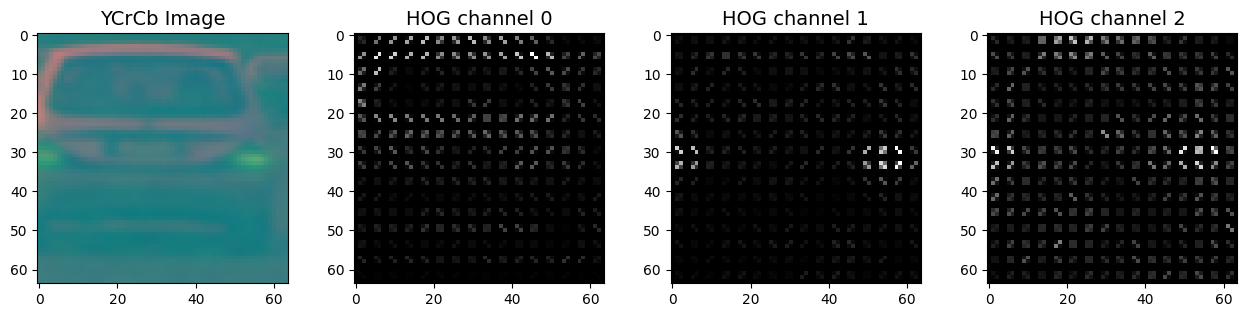

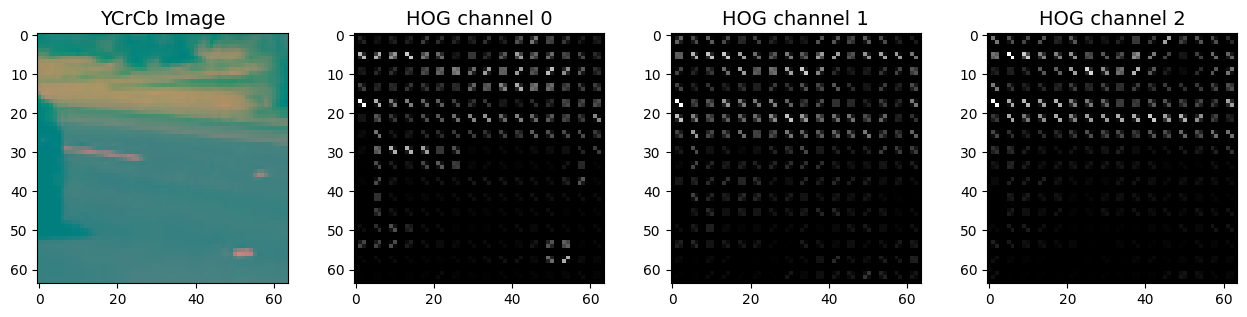

In [3]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import pickle
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
%matplotlib inline
print('Loading dataset...')
cars = ('/home/lakshya/ML/Vehicle-Detection/vehicles/**/*.png')
notcars = ('/home/lakshya/ML/Vehicle-Detection/non-vehicles/**/*.png')
cars = glob.glob(cars, recursive=True)
notcars = glob.glob(notcars, recursive=True)
cars = cars[:1000]
notcars = notcars[:1000]
print('CARS: {}'.format(len(cars)))
print('NOTCARS: {}'.format(len(notcars)))
color_space    = 'YCrCb'    
orient         = 4       
pix_per_cell   = 4     
cell_per_block = 4        
hog_channel    = 'ALL'      
spatial_size   = (32, 32)   
hist_bins      = 32         
spatial_feat   = True       
hist_feat      = True       
hog_feat       = True       

car = mpimg.imread(cars[10])
notcar = mpimg.imread(notcars[10])
car_features = single_img_features(car, color_space=color_space,
                                   spatial_size=spatial_size, hist_bins=hist_bins, 
                                   orient=orient, pix_per_cell=pix_per_cell, 
                                   cell_per_block=cell_per_block, 
                                   hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                   hist_feat=hist_feat, hog_feat=hog_feat)
print('car_features: DONE')
notcar_features = single_img_features(notcar, color_space=color_space,
                                      spatial_size=spatial_size, hist_bins=hist_bins, 
                                      orient=orient, pix_per_cell=pix_per_cell, 
                                      cell_per_block=cell_per_block, 
                                      hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                      hist_feat=hist_feat, hog_feat=hog_feat)
print('notcar_features: DONE')

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import numpy as np
import time
import random

hog_feat=True
hist_feat=True
car_features = extract_features(cars, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)
print('car_features: DONE')
notcar_features = extract_features(notcars, color_space=color_space, 
                                   spatial_size=spatial_size, hist_bins=hist_bins, 
                                   orient=orient, pix_per_cell=pix_per_cell, 
                                   cell_per_block=cell_per_block, 
                                   hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                   hist_feat=hist_feat, hog_feat=hog_feat)
print('notcar_features: DONE')
X = np.vstack((car_features, notcar_features)).astype(np.float64)
print(X.shape)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
rand_state  = 20
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)
print('Using:', orient, 'orientations', pix_per_cell, 
      'pixels per cell and', cell_per_block, 'cells per block')
print('Feature vector length:', len(X_train[0]))
fraction_to_flip = 0.1
num_samples_to_flip = int(fraction_to_flip * len(y_train))
random_indices_to_flip = random.sample(range(len(y_train)), num_samples_to_flip)
y_train[random_indices_to_flip] = 1 - y_train[random_indices_to_flip]
svc = LinearSVC()
t = time.time()
losses_svc = []
for i in range(20):
    svc.fit(X_train, y_train) 
    decision_function = svc.decision_function(X_train)
    loss_value = 0.5 * (1 - y_train * decision_function).clip(min=0).mean() 
    losses_svc.append(loss_value)
t2 = time.time()
print(round(t2 - t, 2), 'Seconds to train LinearSVC...')
plt.figure(figsize=(10, 5))
plt.plot(range(len(losses_svc)), losses_svc, label='LinearSVC Loss')   
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.title('LinearSVC Loss during Training')
plt.show()
test_accuracy = svc.score(X_test, y_test)
print('Test Accuracy of LinearSVC =', round(test_accuracy, 4))

svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2 - t, 2), 'Seconds to train SVC...')

test_accuracy = svc.score(X_test, y_test)
print('Test Accuracy of SVC = ', round(test_accuracy, 4))

loss_values = svc.decision_function(X_train)
rounded_loss_values = [round(value, 4) for value in loss_values]

print('Loss of LinearSVC =', rounded_loss_values)

y_pred = svc.predict(X_test)
f1 = f1_score(y_test, y_pred)
print('F1 Score of Linear SVC =', round(f1, 4))
fraction_to_flip = 0.3
num_samples_to_flip = int(fraction_to_flip * len(y_train))
random_indices_to_flip = random.sample(range(len(y_train)), num_samples_to_flip)
y_train[random_indices_to_flip] = 1 - y_train[random_indices_to_flip]

from sklearn.linear_model import LogisticRegression
logistic_reg = LogisticRegression(C=100)
t = time.time()
losses_logistic = []
for i in range(20): 
    logistic_reg.fit(X_train, y_train)
    y_pred_prob = logistic_reg.predict_proba(X_train)[:, 1]
    loss_value = -np.mean(y_train * np.log(y_pred_prob) + (1 - y_train) * np.log(1 - y_pred_prob))
    losses_logistic.append(loss_value)
t2 = time.time()
print(round(t2 - t, 2), 'Seconds to train Logistic Regression...')

plt.figure(figsize=(10, 5))
plt.plot(range(len(losses_logistic)), losses_logistic, label='Logistic Regression Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.title('Logistic Regression Loss during Training')
plt.show()
test_accuracy = logistic_reg.score(X_test, y_test)
print('Test Accuracy of Logistic Regression =', round(test_accuracy, 4))
logistic_reg.fit(X_train, y_train)
t2 = time.time()
print(round(t2 - t, 2), 'Seconds to train Logistic Regression...')
test_accuracy = logistic_reg.score(X_test, y_test)
print('Test Accuracy of Logistic Regression = ', round(test_accuracy, 4))
loss_value = logistic_reg.loss
print('Loss of Logistic Regression =', round(loss_value, 4))
y_pred = logistic_reg.predict(X_test)
f1 = f1_score(y_test, y_pred)
print('F1 Score of Logistic =', round(f1, 4))

from keras.models import Sequential
from keras.layers import Dense, Dropout

dnn_model = Sequential()
dnn_model.add(Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
dnn_model.add(Dropout(0.5))
dnn_model.add(Dense(128, activation='relu'))
dnn_model.add(Dense(1, activation='sigmoid'))

dnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

t = time.time()
dnn_model.fit(X_train, y_train, batch_size=32, epochs=10)
print(f'Time to train DNN: {time.time() - t:.2f} seconds')

test_loss, test_accuracy = dnn_model.evaluate(X_test, y_test)
print(f'Test Loss for DNN: {test_loss:.4f}')
print(f'Test Accuracy for DNN: {test_accuracy:.4f}')

y_pred_dnn = (dnn_model.predict(X_test) > 0.5).astype("int32")
f1_dnn = f1_score(y_test, y_pred_dnn)
print(f'F1 Score for DNN: {f1_dnn:.4f}') 

2023-11-21 23:40:14.065577: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-21 23:40:14.117247: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-21 23:40:14.291921: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-21 23:40:14.291958: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-21 23:40:14.292781: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

car_features: DONE
notcar_features: DONE
(2000, 35616)
Using: 4 orientations 4 pixels per cell and 4 cells per block
Feature vector length: 35616


/home/lakshya/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/lakshya/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lakshya/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/lakshya/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/lakshya/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` i